# Iterative learning of direct load control sequences

## Ontario winter time-of-use pricing
- Time of use price increases occur at
    - Winter at 7 am
        - Goal is to preheat before 7 am and get through 11 am
        - Penalties for occupant discomfort
    - Summer at 7 am
        - Goal is to precool before 7 am and get through 8 am to 10 am
    - Summer at 11 am
        - Goal is to precool before 11 am and get through 5 pm


## Algorithm
- Define the model predicting the reward $f(x) = r$
- Initialize a random set of $c$ and $x$
- Initialize the learning rate $\eta$

do every workday at 4 am
- Compute the expected reward $\hat{r}$

do every workday at 11 pm
- Compute the actual reward $r$
- Compute the error $e$ between actual and expected reward 
- Update $c$ by $\eta \cdot \frac{de}{dc}$
- Update $x$ by $\eta \cdot \frac{dy}{dc}$
- Reset $s_{hold} = false$

do every timestep
- if an occupant overrides ($s_{hold} = true$), keep user the defined setpoint until the end of occupancy

## Reward
$r = - c_{elec} - s_{hold} \cdot c_{elec}$


In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
import random
import scipy
import sklearn
from scipy import optimize
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
import sys
import time

In [2]:
# initialize the cost model for winter
costMdl_x = MLPRegressor(max_iter=1000, solver='sgd',learning_rate_init = 0.01, hidden_layer_sizes = (10,10,))
# initialize parameters of the DLC sequence x
x = [[np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3)]]
# define search limits for DLC parameters 
bounds_x = [[0,3],[0,3],[0,3]]
# define function to be used in updating the x
def wrapperx(x):
    xp = costMdl_x.predict([[x[0],x[1],x[2]]])
    return xp

# initialize the cost model for summer
costMdl_y = MLPRegressor(max_iter=1000, solver='sgd',learning_rate_init = 0.01, hidden_layer_sizes = (10,10,))
# initialize parameters of the DLC sequence y
y = [[np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3)]]
# define search limits for DLC parameters 
bounds_y = [[0,3],[0,3],[0,3],[0,3],[0,3],[0,3]]
def wrappery(y):
    yp = costMdl_y.predict([[y[0],y[1],y[2],y[3],y[4],y[5]]])
    return yp

a = 8.7*0.01  #$/kWh  off_peak_price
b = 12.2*0.01  #$/kWh  mid_peak_price
c = 18.2*0.01  #$/kWh  on_peak_price
winter_prices = {0:a ,1:a ,2:a ,3:a ,4:a ,5:a ,6:a ,7:c ,8:c ,9:c ,10:c ,11:b ,12:b ,13:b ,14:b ,15:b ,16:b ,17:c ,18:c ,19:a ,20:a ,21:a ,22:a ,23:a }
summer_prices = {0:a ,1:a ,2:a ,3:a ,4:a ,5:a ,6:a ,7:b ,8:b ,9:b ,10:b ,11:c ,12:c ,13:c ,14:c ,15:c ,16:c ,17:b ,18:b ,19:a ,20:a ,21:a ,22:a ,23:a }
J_2_kWh = 1/3600000

discomfort_totalizer = 0
energy_totalizer = 0
cost_x = 0 # winter daily cost
cost_y = 0 # summer daily cost

exploration_x_count = 0
exploration_y_count = 0

store_x = []
store_y = []
cost_winter = []
cost_summer = []
        
def my_callback_function(state):
    global discomfort_totalizer, energy_totalizer, x, y, cost_x, cost_y, exploration_x_count, exploration_y_count
    envNum = api.exchange.current_environment_num(state)
    if envNum == 3: # if sizing done
        tSetHtg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetHtg")
        tSetClg_hndl = api.exchange.get_actuator_handle(state, "Schedule:Constant", "Schedule Value", "tSetClg")
        elect_hndl = api.exchange.get_meter_handle(state,"Electricity:Facility")
        tIn_office_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Office")
        tIn_lobby_hndl = api.exchange.get_variable_handle(state,"Zone Mean Air Temperature","Lobby")

        # exchange information with EnergyPlus
        meter_reading = api.exchange.get_meter_value(state,elect_hndl)
         
        tIn_office = api.exchange.get_variable_value(state,tIn_office_hndl)
        tIn_lobby = api.exchange.get_variable_value(state,tIn_lobby_hndl)
        month = api.exchange.month(state) 
        time_of_day = api.exchange.hour(state)
        day_of_week = api.exchange.day_of_week(state)
        day_of_month = api.exchange.day_of_month(state)
        
        # calculate price based on time of day & season
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 7):  # winter, weekday
            energy_dollars = meter_reading * J_2_kWh * winter_prices[time_of_day]
        elif ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 7): # summer, weekday
            energy_dollars = meter_reading * J_2_kWh * summer_prices[time_of_day]
        else:  # weekend
            energy_dollars = meter_reading * J_2_kWh * a
                
        
        api.exchange.set_actuator_value(state, tSetHtg_hndl, 18)
        api.exchange.set_actuator_value(state, tSetClg_hndl, 27)

        if (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7 and time_of_day < 17):
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21)
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24)

        # actuate setpoints based on winter DLC parameter array x
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7 - x[0][0]) and (time_of_day < 7): # preheat winter off-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21 + x[0][1])
            if (time_of_day > 7) and (time_of_day < 11): # setback winter on-peak
                api.exchange.set_actuator_value(state, tSetHtg_hndl, 21 - x[0][2])

        # actuate setpoints based on summer parameter array y   
        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day > 7 - y[0][0]) and (time_of_day < 7): # precool summer off-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 - y[0][1])
            if (time_of_day > 7) and (time_of_day < 7 + y[0][2]): # setup summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + y[0][3])
            if (time_of_day > 7 + y[0][2]) and (time_of_day < 11): # precool summer mid-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 - y[0][4])
            if (time_of_day > 11) and (time_of_day < 17): # setup summer on-peak
                api.exchange.set_actuator_value(state, tSetClg_hndl, 24 + y[0][5])

        # at the end of the day update cost_x to update cost model for winter
        if ((month > 10) or (month < 5)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day < 23):
                cost_x = 0
                energy_totalizer = energy_totalizer + energy_dollars
                if (time_of_day > 8 and time_of_day < 17):
                    if ((tIn_office < 20) or (tIn_office > 25) or (tIn_lobby < 20) or (tIn_lobby > 25)):
                        discomfort_totalizer = discomfort_totalizer + 1
            elif (cost_x == 0):
                cost_x = (energy_totalizer) * (1 + (discomfort_totalizer > 4)) + 0.0000001
                discomfort_totalizer = 0
                energy_totalizer = 0
                costMdl_x.partial_fit(x, [cost_x])
                # update x for the next iteration
                if (exploration_x_count < 100) or (np.random.uniform(0,1) <= 0.01): #through exploration
                    exploration_x_count = exploration_x_count + 1
                    x = [[np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3)]]
                else: # through exploitation
                    results = scipy.optimize.shgo(wrapperx,bounds_x,n=100, iters=1, sampling_method = 'halton')
                    x = [[results.x[0],results.x[1],results.x[2]]]
#                 print(cost_x)
#                 print(month)
                cost_winter.append(cost_x)


        # at the end of the day update cost_y to update cost model for summer
        if ((month > 4) and (month < 11)) and (day_of_week > 1 and day_of_week < 7):
            if (time_of_day < 23):
                cost_y = 0
                energy_totalizer = energy_totalizer + energy_dollars
                if (time_of_day > 8 and time_of_day < 17):
                    if ((tIn_office < 20) or (tIn_office > 25) or (tIn_lobby < 20) or (tIn_lobby > 25)):
                        discomfort_totalizer = discomfort_totalizer + 1
            elif (cost_y == 0):
                cost_y = (energy_totalizer) * (1 + (discomfort_totalizer > 4)) + 0.0000001
                discomfort_totalizer = 0
                energy_totalizer = 0
                costMdl_y.partial_fit(y, [cost_y])
                # update y for the next iteration
                if (exploration_y_count < 100) or (np.random.uniform(0,1) <= 0.01): #through exploration
                    exploration_y_count = exploration_y_count + 1
                    y = [[np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3),np.random.uniform(0,3)]]
                else: # through exploitation
                    results = scipy.optimize.shgo(wrappery,bounds_y,n=100, iters=1, sampling_method = 'halton')
                    y = [[results.x[0],results.x[1],results.x[2],results.x[3],results.x[4],results.x[5]]]
                cost_summer.append(cost_y)
        
        store_x.append(x)
        store_y.append(y)
        
        

In [3]:
import sys
sys.path.insert(0, 'C:\EnergyPlusV23-1-0')  # add E-Plus directory to path to be able to import API
from pyenergyplus.api import EnergyPlusAPI #import EnergyPlus library
api = EnergyPlusAPI()
for i in range(10):
    state = api.state_manager.new_state() 
    api.runtime.clear_callbacks()
    api.functional.clear_callbacks()
    # energyplus model calling point, callback function
    api.runtime.callback_begin_system_timestep_before_predictor(state,my_callback_function)
    # run EPlus
    epwFile = 'ON_OTTAWA-INTL-ONT_716280_19.epw'
    idfFile = 'baseline.idf'
    # -x short form to run expandobjects for HVACtemplates. see EnergyPlusEssentials.pdf p16
    cmd_args = ['-w',epwFile, '-d', 'out','-x',idfFile]
    api.runtime.run_energyplus(state,cmd_args)

In [4]:
df_basecase = pd.read_csv('base_case_data.csv')

1362

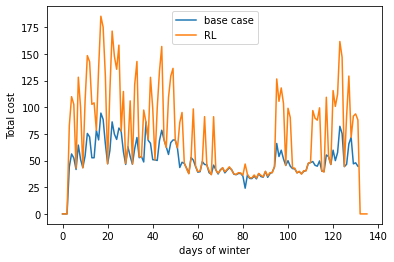

In [41]:
plt.plot(df_basecase["cost_winter"], label="base case")
i = 0
plt.plot(cost_winter[i*136+14:(i+1)*136+14], label="RL")
plt.legend()
plt.xlabel("days of winter")
plt.ylabel("Total cost")
len(cost_winter)

1320

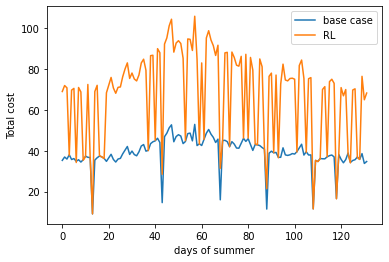

In [42]:
plt.plot(df_basecase["cost_summer"], label="base case")
i = 0
plt.plot(cost_summer[i*132:(i+1)*132], label="RL")
plt.legend()
plt.xlabel("days of summer")
plt.ylabel("Total cost")
len(cost_summer)

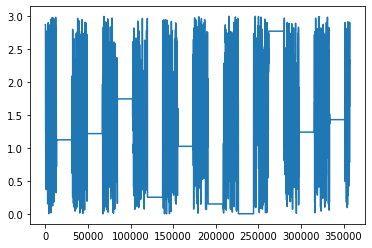

In [38]:
arr_x = np.array(store_x)
par_1 = arr_x[:,0,:][:,0]
par_2 = arr_x[:,0,:][:,1]
par_3 = arr_x[:,0,:][:,2]
plt.plot(par_2)

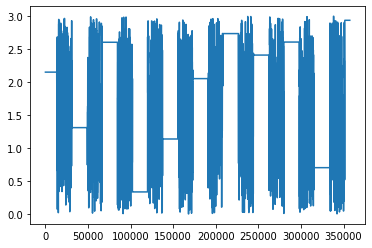

In [39]:
arr_y = np.array(store_y)
par_1 = arr_y[:,0,:][:,0]
par_2 = arr_y[:,0,:][:,1]
par_3 = arr_y[:,0,:][:,2]
par_4 = arr_y[:,0,:][:,3]
par_5 = arr_y[:,0,:][:,4]
par_6 = arr_y[:,0,:][:,5]
plt.plot(par_1)